In [1]:
## Limit tensorflow usage
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction=0.01
conf.gpu_options.visible_device_list = "0,2"
session = tf.Session(config=conf)

## First edward program

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

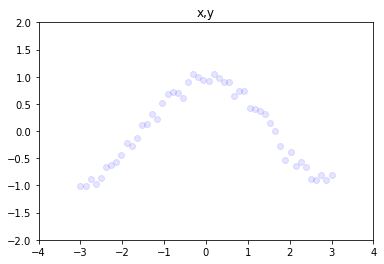

In [11]:

plt.scatter(x_train, y_train, color='blue', alpha=0.1)
plt.axis([-4, 4, -2.0, 2.0])
plt.title("x,y")
plt.show()

In [8]:
plt.show()

In [3]:
import tensorflow as tf
from edward.models import Normal

W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [4]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [5]:
import edward as ed

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000)

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -18.245


## Gibbs inference Eg.

In [1]:
## 01
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
from scipy import stats
import edward as ed

df = pd.DataFrame(load_iris()['data'])
y = df.values
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

# A 2D pairplot between variables
df['target'] = load_iris()['target']
sns.pairplot(df, hue='target', vars=[0, 1, 2, 3])

In [2]:
## 02
k = 3  # number of clusters

d = df.shape[1]
n = df.shape[0]

pi = ed.models.Dirichlet(tf.ones(k))
mu = ed.models.Normal(tf.zeros(d), tf.ones(d), sample_shape=k)  # shape (3, 4) 3 gaussians, 4 variates
sigmasq = ed.models.InverseGamma(tf.ones(d), tf.ones(d), sample_shape=k)
x = ed.models.ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 ed.models.MultivariateNormalDiag,
                 sample_shape=n)
z = x.cat

In [3]:
## 03
t = 500  # number of samples

qpi = ed.models.Empirical(tf.get_variable('qpi', shape=[t, k], initializer=tf.constant_initializer(1 / k)))
qmu = ed.models.Empirical(tf.get_variable('qmu', shape=[t, k, d], initializer=tf.zeros_initializer()))
qsigmasq = ed.models.Empirical(tf.get_variable('qsigmasq', shape=[t, k, d], initializer=tf.ones_initializer()))
qz = ed.models.Empirical(tf.get_variable('qz', shape=[t, n], initializer=tf.zeros_initializer(), dtype=tf.int32)) 

In [12]:
## 04
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, 
                    data={x: y})
inference.run()

In [8]:
## 05
qsigmasq.shape

TensorShape([Dimension(3), Dimension(5)])

In [ ]:
## 06
mu_s = qmu.sample(500).eval()
sigmasq_s = qsigmasq.sample(500).eval()
pi_s = qpi.sample(500).eval()

In [ ]:
## 07
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title(r'Distribution of the likelihood of $\mu | X$ in all dimensions')
plt.ylabel(r'$P(\mu|X)$')
plt.xlabel(r'$\mu$')
for i in range(3):
    for j in range(4):
        sns.distplot(mu_s[:, i, j], hist=False)

In [ ]:
## 08
np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
           for i in range(3)]).argmax(axis=0)

In [ ]:
## 09
np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
          for i in range(3)])[::-1].argmax(axis=0).sum() / df.shape[0]

In [13]:
## 10
##{x:y}

In [11]:
## 11
df.values.shape

(150, 5)

## Data Subgsampling 

In [2]:
from edward.models import Categorical, Normal

N = 10000000  # data set size
M = 128  # minibatch size
D = 2  # data dimensionality
K = 5  # number of clusters

beta = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
z = Categorical(logits=tf.zeros([M, K]))
x = Normal(loc=tf.gather(beta, z), scale=tf.ones([M, D]))

In [3]:
qbeta = Normal(loc=tf.Variable(tf.zeros([K, D])),
               scale=tf.nn.softplus(tf.Variable(tf.zeros[K, D])))
qz_variables = tf.Variable(tf.zeros([M, K]))
qz = Categorical(logits=qz_variables)

TypeError: 'function' object is not subscriptable

## corrLDA

In [1]:
## packages
import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Categorical, Dirichlet


In [ ]:
## eg

X = tf.placeholder(tf.float32, [N, 2])
sigma = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
beta = Normal(loc=tf.zeros(2), scale=tf.ones(2))
alpha = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, beta) + alpha, scale=sigma * tf.ones(N))

In [3]:
pres_data = np.random.randint(2,size=(10,19))
diag_data = np.random.randint(2,size =(10,32))

In [ ]:
import tensorflow as tf


D = 4  # number of documents
N = [11502, 213, 1523, 1351]  # words per doc
K = 10  # number of topics
V = 100000  # vocabulary size

theta = Dirichlet(tf.zeros([D, K]) + 0.1)
phi = Dirichlet(tf.zeros([K, V]) + 0.05)
z = [[0] * N] * D
w = [[0] * N] * D
for d in range(D):
  for n in range(N[d]):
    z[d][n] = Categorical(theta[d, :])
    w[d][n] = Categorical(phi[z[d][n], :])

In [ ]:
D,W= data.shape
K=5
V=W
alpha = np.ones((1, K))
beta = np.ones((1, V))
with pm.Model() as model:
    thetas = pm.Dirichlet("thetas", a=alpha, shape=(D, K))
    phis = pm.Dirichlet("phis", a=beta, shape=(K, V))
    z = pm.Categorical("zx", p=thetas, shape=(W, D))
    w = pm.Categorical("wx", 
                       p=t.reshape(phis[z], (D*W, V)), 
                       observed=data.reshape(D*W))

In [33]:
D,W= pres_data.shape
K=5
V=W
alpha = tf.zeros((D,K))+0.1
beta = tf.zeros((K,V))+0.1

theta = Dirichlet(prob=alpha)
phi = Dirichlet(prob=beta)


z  = Categorical(tf.gather(theta, tf.gather(doc, tf.range(N))))
w  = Categorical(tf.gather(phi, tf.gather(z, tf.range(N))))
z[d][nw] = Categorical(theta[d, :],sample_shape=(D,K))
w[d][nw] = Categorical(phi[z[d][nw], :])

ValueError: setting an array element with a sequence.

In [32]:
n_samples = 500

inference = ed.Gibbs({}, data={w:pres_data})
inference.run()

TypeError: unhashable type: 'list'

In [37]:
from edward.models import Beta, Bernoulli, Empirical
x_data = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

p = Beta(1.0, 1.0)
x = Bernoulli(probs=p, sample_shape=10)

qp = Empirical(tf.Variable(tf.zeros(500)))
inference = ed.Gibbs({p: qp}, data={x: x_data})

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [38]:
inference.run()

500/500 [100%] ██████████████████████████████ Elapsed: 4s | Acceptance Rate: 1.000


In [42]:
qp

<ed.RandomVariable 'Empirical/' shape=() dtype=float32>

In [12]:
z[5][1]

0

## Collapsed Gibbs Sampling for LDA 

In [2]:
# from future import absolute_import
# from future import division
# from future import print_function

from time import time

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow as tf
from edward.models import (Dirichlet, Categorical, ParamMixture, Multinomial)

D = 10
N = 200
K = 4

sess = session

In [3]:
## generate simulated data
arr = tf.ones(K)
# arr = np.random.rand(N) * 4.0

alpha_test = np.divide(arr,np.sum(arr))

theta_test = Dirichlet(concentration=alpha_test, sample_shape=D)


arr = tf.ones(N)
beta_test= np.divide(arr,np.sum(arr))
phi_test = Dirichlet(beta_test,sample_shape=K)


mix_test = [0]*D
z_test=[0]*D
for d in range(D):
    mix_test[d] = ParamMixture(mixing_weights=tf.gather(theta_test,d),
                        component_params={'probs':phi_test},
                        component_dist=Categorical,
                        sample_shape=N)
#         theta_test[d,:],{'probs' : phi_test}, Categorical,sample_shape=N)
    z_test[d]= mix_test[d].cat

mix_data, z_data = sess.run([mix_test, z_test])

In [4]:
## LDA model definition
alpha = tf.ones(K)
theta = Dirichlet(alpha,sample_shape=D)
beta = tf.ones(N)
phi = Dirichlet(beta,sample_shape=K)

mix = [0]*D
z=[0]*D

for d in range(D):
    mix[d] = ParamMixture(mixing_weights=tf.gather(theta,d),
                          component_params={'probs':phi},
                          component_dist=Categorical,
                          sample_shape=N)
    z[d]= mix[d].cat

# https://github.com/blei-lab/edward/issues/423
#     for n in range(N):
#         z[d][n] = Categorical(logits=tf.gather(theta, d))
#         w[d][n] = Categorical(logits=tf.gather(phi, z[d][n]))

In [5]:
t = 500  # number of samples

qtheta = ed.models.Empirical(tf.get_variable('qtheta', shape=[t, D, K], initializer=tf.constant_initializer(1 / K)))
qphi = ed.models.Empirical(tf.get_variable('qphi', shape=[t, K, N], initializer=tf.constant_initializer(1 / N)))

qz=[0]*D
for d in range(D):
    qz[d] = ed.models.Empirical(tf.get_variable('qz{}'.format(d), shape=[t, N], initializer=tf.zeros_initializer(), dtype=tf.int32)) 


In [7]:
infer_dict = {theta:qtheta, phi:qphi}
data_dict={}
for d in range(D):
    infer_dict[z[d]]=qz[d]
    data_dict[mix[d]]=mix_data[d]

inference = ed.HMC(infer_dict, data=data_dict)
inference.run()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


ValueError: input_shape.dims = 2 != 1

In [8]:
infer_dict

{<ed.RandomVariable 'Dirichlet_2/' shape=(10, 4) dtype=float32>: <ed.RandomVariable 'Empirical/' shape=(10, 4) dtype=float32>,
 <ed.RandomVariable 'Dirichlet_3/' shape=(4, 200) dtype=float32>: <ed.RandomVariable 'Empirical_1/' shape=(4, 200) dtype=float32>,
 <ed.RandomVariable 'ParamMixture_10/Categorical/' shape=(200,) dtype=int32>: <ed.RandomVariable 'Empirical_2/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_11/Categorical/' shape=(200,) dtype=int32>: <ed.RandomVariable 'Empirical_3/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_12/Categorical/' shape=(200,) dtype=int32>: <ed.RandomVariable 'Empirical_4/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_13/Categorical/' shape=(200,) dtype=int32>: <ed.RandomVariable 'Empirical_5/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_14/Categorical/' shape=(200,) dtype=int32>: <ed.RandomVariable 'Empirical_6/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_15/Categorica

In [32]:
z

[<ed.RandomVariable 'ParamMixture_10/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_11/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_12/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_13/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_14/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_15/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_16/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_17/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_18/Categorical/' shape=(200,) dtype=int32>,
 <ed.RandomVariable 'ParamMixture_19/Categorical/' shape=(200,) dtype=int32>]

In [24]:
# theta_cond=[0]*D
# for d in range(D):
#     theta_cond[d] = ed.complete_conditional(tf.gather(theta, d))

In [47]:
## initialized estimated params
theta_est,beta_est,z_est = sess.run([theta, beta, z])


<ed.RandomVariable 'Dirichlet_25/' shape=(4, 200) dtype=float32>

IndexError: list assignment index out of range

In [8]:
mix_data

array([ 55, 132, 171, 194,  99, 179,  93,  41, 106, 152, 139,  29, 183,
        40, 167,  22, 130,  89, 167,  57, 157,  58, 156,  77,  13, 167,
       109, 195, 199, 130,  14,  99,  97,  99,  68,  63,  30,  73,   4,
        86,  32,  55, 146, 158, 181, 127, 149,   9, 109,  50,  98,  18,
       195, 166, 107,  30, 131, 161, 167,  51,  69,  28,  86,  77,  57,
        96,  73, 117,  49,  16, 167,  13,  23,  68, 171, 105,  83, 183,
        80, 160,  18,  30, 131,  85,  26, 153,  93, 160,  26,  36,  38,
       173, 192,  13, 149,  35,  71,  89,  57, 188, 101,  77,  72,   7,
       146,  29,   0, 123,  26, 193,  32, 110,  19, 123, 166, 153, 195,
        36,  79,  68, 183, 185,  14, 106, 146,  38,   3,  79,  96, 134,
       141,  66,  67, 116,  25,   5, 180,  30,  84,   4, 117,  95, 106,
        70,  55,  80,  96, 123,  41,  98,  95,  63, 104,  42, 190,  47,
        49, 180,  55,  27, 147,  87,  42,  66, 102,  36,  55,  16, 195,
       127,  26,   3,  13, 168,  13,  73,  84, 195,  63, 119, 10

In [5]:
alpha = tf.ones(K)
theta = Dirichlet(alpha)
gamma = tf.ones(N)
beta = Dirichlet(gamma,sample_shape=K)
mix = ParamMixture(theta,{'probs':beta}, Categorical,sample_shape=N)
z = mix.cat

In [6]:
theta_cond = ed.complete_conditional(theta)
beta_cond = ed.complete_conditional(beta)
z_cond = ed.complete_conditional(z)

In [3]:
sess=session
## Test
theta_est,beta_est,z_est = sess.run([theta, beta, z])

mix_data, z_data = sess.run([mix_test, z_test])

mix_data = np.reshape(mix_data,(N,))
theta_est = np.reshape(np.asarray(theta_est),(K,))

print('Test parameters:')
print('theta:', sess.run(theta_test))

print('Initial parameters:')
print('theta:', theta_est)
#print(gamma:’, gamma_est)
print()

NameError: name 'theta' is not defined

took 205.696 seconds to run 50000 iterations

Final parameters::
theta: [0.01878781 0.37393284 0.3884576  0.21882175]


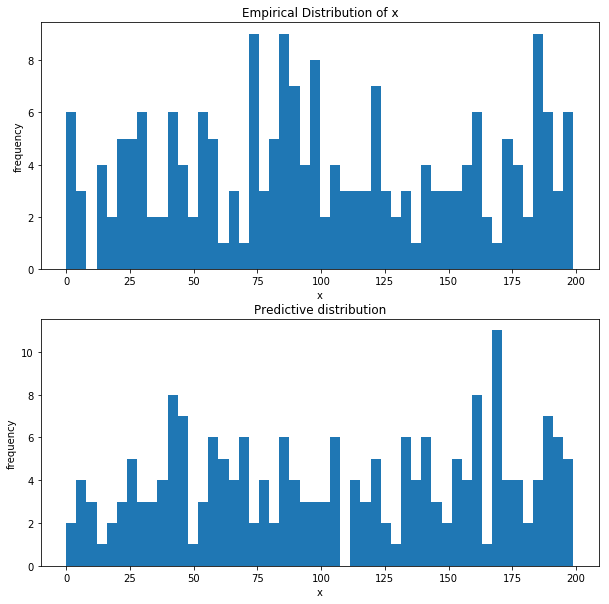

In [12]:
cond_dict = {theta: theta_est, beta: beta_est, z: z_est, mix: mix_data}
t0 = time()
T = 50000
for t in range(T):
    z_est = sess.run(z_cond, cond_dict)
    cond_dict[z] = z_est
    theta_est = np.reshape(np.asarray(sess.run([theta_cond], cond_dict)),(K,))
    cond_dict[theta] = theta_est
    beta_est = sess.run(beta_cond, cond_dict)
    cond_dict[beta] = beta_est

print('took %.3f seconds to run %d iterations' % (time() - t0, T))

print()
print('Final parameters::')
print('theta:', theta_est)

plt.figure(figsize=[10, 10])
plt.subplot(2, 1, 1)
plt.hist(mix_data, 50)
plt.title('Empirical Distribution of x')
plt.xlabel('x')
plt.ylabel('frequency')
xl = plt.xlim()
plt.subplot(2, 1, 2)
plt.hist(sess.run(mix,{theta: theta_est, beta: beta_est,z: z_est}), 50)
plt.title("Predictive distribution")
plt.xlabel('x')
plt.ylabel('frequency')
plt.xlim(xl)
plt.show()

## LDA python

In [9]:
# Dirichlet priors 
alpha = 1
gamma = 1

# Z := word topic assignment Z = np.zeros(shape=[N_D, N_W])

for i in range(N_D):
    for l in range(N_W):
        Z[i, l] = np.random.randint(N_K)  # randomly assign word's topic 
# Pi := document topic distribution Pi = np.zeros([N_D, N_K])

for i in range(N_D):
    Pi[i] = np.random.dirichlet(alpha*np.ones(N_K))

# B := word topic distribution B = np.zeros([N_K, N_W])

for k in range(N_K):
    B[k] = np.random.dirichlet(gamma*np.ones(N_W))

NameError: name 'N_D' is not defined